# 🔮 **Predicción de Renuncia de Clientes**🔮
---


In [4]:
# Importamos librerías para manipulación de datos
import numpy as np
import pandas as pd
from collections import Counter

# Importamos librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Importamos herramientas de Scikit-learn para preprocesamiento, entrenamiento y evaluación
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

# Importamos SMOTE para el balanceo de clases
from imblearn.over_sampling import SMOTE

# Importamos TensorFlow y Keras para construir redes neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping


In [5]:
# Cargando el archivo CSV con los datos de clientes y su información de churn
print("📂 Cargando el dataset 'Customer Churn.csv'...")

df = pd.read_csv('Customer Churn.csv')

# Mostramos las primeras 5 filas del DataFrame para conocer su estructura
print("👀 Visualizando las primeras filas del dataset:")
df.head()


📂 Cargando el dataset 'Customer Churn.csv'...
👀 Visualizando las primeras filas del dataset:


,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


## 🧾 Diccionario de Variables

- **Call Failures:** Número de fallos de llamadas.  
- **Complaints:** Quejas (1) o ninguna queja (0).  
- **Subscription Length:** Meses totales de suscripción.  
- **Charge Amount:** Importe del cargo, atributo ordinal (0: importe más bajo, 9: importe más alto).  
- **Seconds of Use:** Segundos totales de llamadas.  
- **Frequency of use:** Número total de llamadas realizadas.  
- **Frequency of SMS:** Número total de mensajes de texto enviados.  
- **Distinct Called Numbers:** Número total de números distintos a los que se ha llamado.  
- **Age Group:** Grupo de edad, atributo ordinal (1: menor edad, 5: mayor edad).  
- **Tariff Plan:** Tipo de plan, binario (1: pago por uso, 2: contractual).  
- **Status:** Estado del cliente, binario (1: activo, 2: inactivo).  
- **Churn:** Cancelación del servicio, binario (1: cliente que se dio de baja, 0: cliente que sigue). **(Etiqueta objetivo)**  
- **Customer Value:** Valor calculado del cliente (métrica del negocio).



In [6]:
# Mostramos la cantidad de filas y columnas del DataFrame
print("📐 Verificando la dimensión del DataFrame...")

print(f"El DataFrame tiene {df.shape[0]} filas y {df.shape[1]} columnas.")


📐 Verificando la dimensión del DataFrame...
El DataFrame tiene 3150 filas y 14 columnas.


In [7]:
# Analizamos los caracteres únicos presentes en cada columna para detectar posibles símbolos o formatos no deseados
print("🧪 Analizando los caracteres presentes en cada columna...")

for col in df.columns:
    caracteres = set()
    for valor in df[col].astype(str):  # Convertimos a string para asegurar uniformidad
        caracteres.update(valor)
    print(f"Columna '{col}': {sorted(caracteres)}")
    print("-" * 40)


🧪 Analizando los caracteres presentes en cada columna...
Columna 'Call  Failure': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
----------------------------------------
Columna 'Complains': ['0', '1']
----------------------------------------
Columna 'Subscription  Length': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
----------------------------------------
Columna 'Charge  Amount': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
----------------------------------------
Columna 'Seconds of Use': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
----------------------------------------
Columna 'Frequency of use': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
----------------------------------------
Columna 'Frequency of SMS': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
----------------------------------------
Columna 'Distinct Called Numbers': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
----------------------------------------
Columna 'Age Group': ['1',

## ✅ Revisión de símbolos en los datos

Se verificó la presencia de caracteres especiales o símbolos en las columnas del dataset.  
🔍 **Resultado:** No se encontraron símbolos que puedan dificultar el análisis.

📌 **Observaciones:**
- Todas las columnas contienen datos numéricos apropiados.
- La única excepción es la columna `Customer Value`, que contiene el punto decimal (`.`), lo cual es **esperado** y **correcto** para datos tipo `float64`.

✅ **Conclusión:**  
Los datos están limpios y **listos para su análisis** en cuanto a formato de caracteres.


In [8]:
# Inspeccionamos los tipos de datos de cada columna y la presencia de valores nulos
print("🔎 Revisando tipos de datos y valores nulos en el DataFrame...")

df.info()

🔎 Revisando tipos de datos y valores nulos en el DataFrame...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn           

## 🧠 Conversión de columnas a tipo categórico

Al analizar nuestro DataFrame, observamos que varias columnas que representan variables categóricas o binarias están almacenadas como enteros (`int64`). Aunque esto es válido, existen buenas razones para convertirlas a tipo categórico (`category`):

- **🔋 Eficiencia de memoria:**  
  Las columnas categóricas ocupan menos espacio y mejoran el rendimiento.

- **🧾 Claridad semántica:**  
  Ayuda a diferenciar entre variables numéricas continuas y categorías discretas.

- **📊 Mejor desempeño en análisis/modelado:**  
  Algunos algoritmos interpretan mejor las variables categóricas al tratarlas como tal.

- **🛡️ Prevención de errores:**  
  Evita cálculos incorrectos como promedios o sumas sobre variables que no lo permiten.

### 🎯 Columnas a convertir:
- `Complains`  
- `Tariff Plan`  
- `Status`  
- `Churn`  
- `Age Group` (ordinal, pero útil como categórica para ciertos análisis)

Estas conversiones facilitarán un análisis más claro y eficiente.


In [9]:
# Definimos las columnas que deben ser tratadas como categóricas
print("📋 Definiendo columnas categóricas a convertir...")
columnas_categoricas = ['Complains', 'Tariff Plan', 'Status', 'Churn', 'Age Group']

# Realizamos la conversión a tipo 'category' para mejorar claridad y eficiencia
print("🔄 Convirtiendo columnas a tipo 'category'...")
for col in columnas_categoricas:
    df[col] = df[col].astype('category')

# Verificamos que los tipos de datos se hayan actualizado correctamente
print("📊 Tipos de datos actualizados:")
print(df.dtypes)


📋 Definiendo columnas categóricas a convertir...
🔄 Convirtiendo columnas a tipo 'category'...
📊 Tipos de datos actualizados:
Call  Failure                 int64
Complains                  category
Subscription  Length          int64
Charge  Amount                int64
Seconds of Use                int64
Frequency of use              int64
Frequency of SMS              int64
Distinct Called Numbers       int64
Age Group                  category
Tariff Plan                category
Status                     category
Age                           int64
Customer Value              float64
Churn                      category
dtype: object


In [10]:
# Análisis estadístico de variables numéricas
print("📈 Análisis estadístico de variables numéricas:")
display(df.describe().round(2))

print("\n" + "="*80 + "\n")

# Análisis estadístico de variables categóricas
print("📊 Análisis estadístico de variables categóricas:")
display(df.describe(include=['category', 'object']))

print("\n" + "="*80 + "\n")


📈 Análisis estadístico de variables numéricas:


,Call Failure,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age,Customer Value
count,3150.00,3150.00,3150.00,3150.00,3150.00,3150.00,3150.00,3150.00,3150.00
mean,7.63,32.54,0.94,4472.46,69.46,73.17,23.51,31.00,470.97
std,7.26,8.57,1.52,4197.91,57.41,112.24,17.22,8.83,517.02
min,0.00,3.00,0.00,0.00,0.00,0.00,0.00,15.00,0.00
25%,1.00,30.00,0.00,1391.25,27.00,6.00,10.00,25.00,113.80
50%,6.00,35.00,0.00,2990.00,54.00,21.00,21.00,30.00,228.48
75%,12.00,38.00,1.00,6478.25,95.00,87.00,34.00,30.00,788.39
max,36.00,47.00,10.00,17090.00,255.00,522.00,97.00,55.00,2165.28




📊 Análisis estadístico de variables categóricas:


,Complains,Age Group,Tariff Plan,Status,Churn
count,3150,3150,3150,3150,3150
unique,2,5,2,2,2
top,0,3,1,1,0
freq,2909,1425,2905,2368,2655


## 📊 Análisis Estadístico del Dataset

### 🔢 Variables Numéricas

- El dataset contiene **3150 registros** y las principales variables numéricas son:  
  `Call Failure`, `Subscription Length`, `Charge Amount`, `Seconds of Use`, `Frequency of use`, `Frequency of SMS`, `Distinct Called Numbers`, `Age` y `Customer Value`.

- **Valores promedio destacados:**
  - Promedio de fallos de llamada: **7.63**  
  - Duración promedio de suscripción: **32.54 meses**  
  - Importe promedio del cargo: **0.94** (en escala ordinal de 0 a 9)  
  - Segundos promedio de uso: **4472.46**  
  - Frecuencia promedio de llamadas: **69.46**  
  - Frecuencia promedio de SMS: **73.17**  
  - Edad promedio: **31 años**  
  - Valor promedio del cliente: **470.97**

- **Variabilidad observada (desviación estándar):**
  - Alta en:  
    - `Seconds of Use` → **4197.91**  
    - `Frequency of SMS` → **112.24**
  - Baja en:
    - `Charge Amount` → **1.52**

- **Rangos amplios detectados:**
  - `Seconds of Use` llega hasta **17090**
  - `Frequency of SMS` llega hasta **522**

---

### 🏷️ Variables Categóricas

- Variables categóricas clave:  
  `Complains`, `Age Group`, `Tariff Plan`, `Status` y `Churn`.

- **Distribución observada:**
  - `Complains` y `Churn`:  
    Binarias (0 y 1) con **mayoría de clientes sin quejas ni cancelación**  
    - Ejemplo: **2909 sin quejas**
  
  - `Age Group`:  
    5 grupos de edad, con **grupo 3 como el más frecuente**
  
  - `Tariff Plan` y `Status`:  
    Binarias, con **mayoría en la categoría 1**

---

### ✅ Conclusión

- El dataset está **bien estructurado**, con variables numéricas y categóricas claramente diferenciadas.
- Las variables numéricas muestran **dispersión suficiente** para ser útiles en modelos predictivos.
- Las variables categóricas tienen **una distribución clara y balanceada**, lo que facilitará su codificación y análisis en modelos de clasificación.


In [11]:
# Fijamos semillas para reproducibilidad
# Esto asegura que cualquier proceso aleatorio (como SMOTE, train_test_split o entrenamiento de redes)
# produzca resultados consistentes en cada ejecución.
print("🔁 Fijando semillas aleatorias para reproducibilidad...")
np.random.seed(42)
tf.random.set_seed(42)

# Codificación de variables categóricas
print("🔡 Codificando variables categóricas con LabelEncoder...")
cat_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()
print("Variables categóricas:", cat_cols)

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Separación de variables predictoras (X) y la variable objetivo (y)
print("📤 Separando variables independientes (X) y objetivo (y = Churn)...")
X = df.drop('Churn', axis=1)
y = df['Churn']

# División del dataset en entrenamiento (67%) y prueba (33%)
print("📂 Dividiendo el dataset en entrenamiento y prueba con estratificación...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

# Confirmamos tamaños
print(f"✅ Tamaño del set de entrenamiento: {X_train.shape}")
print(f"✅ Tamaño del set de prueba: {X_test.shape}")


🔁 Fijando semillas aleatorias para reproducibilidad...
🔡 Codificando variables categóricas con LabelEncoder...
Variables categóricas: ['Complains', 'Age Group', 'Tariff Plan', 'Status', 'Churn']
📤 Separando variables independientes (X) y objetivo (y = Churn)...
📂 Dividiendo el dataset en entrenamiento y prueba con estratificación...
✅ Tamaño del set de entrenamiento: (2110, 13)
✅ Tamaño del set de prueba: (1040, 13)


🔄 Aplicando SMOTE para balancear las clases del set de entrenamiento...
📊 Distribución de clases antes de SMOTE:
Counter({0: 1778, 1: 332})

📊 Distribución de clases después de SMOTE:
Counter({0: 1778, 1: 1778})


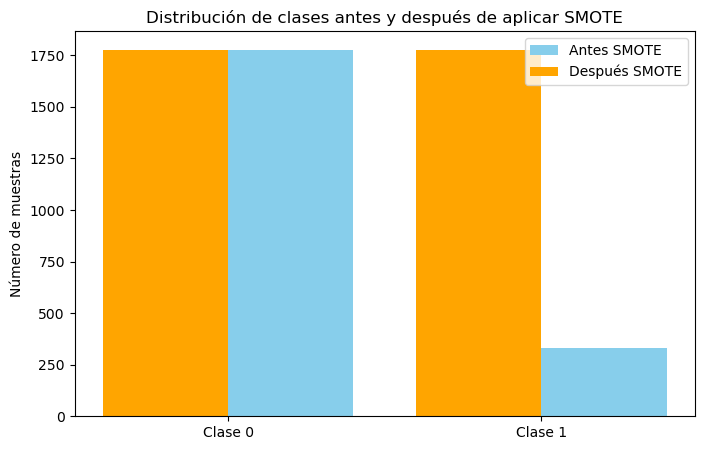

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

# Distribución original en el set de entrenamiento
counter_orig = Counter(y_train)

# Aplicamos SMOTE para balancear el conjunto de entrenamiento
print("🔄 Aplicando SMOTE para balancear las clases del set de entrenamiento...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Distribución después de SMOTE
counter_res = Counter(y_train_res)

# Mostrar conteos en consola
print("📊 Distribución de clases antes de SMOTE:")
print(counter_orig)
print("\n📊 Distribución de clases después de SMOTE:")
print(counter_res)

# Graficar comparativo
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(counter_orig.keys(), counter_orig.values(), width=0.4, label='Antes SMOTE', align='edge', color='skyblue')
ax.bar(counter_res.keys(), counter_res.values(), width=-0.4, label='Después SMOTE', align='edge', color='orange')
ax.set_xticks([0,1])
ax.set_xticklabels(['Clase 0', 'Clase 1'])
ax.set_ylabel('Número de muestras')
ax.set_title('Distribución de clases antes y después de aplicar SMOTE')
ax.legend()
plt.show()


In [13]:
# Escalado de variables usando StandardScaler
print("📏 Aplicando StandardScaler para normalizar características...")

scaler = StandardScaler()

# Ajustamos el escalador SOLO sobre el set de entrenamiento balanceado
X_train_res_scaled = scaler.fit_transform(X_train_res)

# Aplicamos la transformación al set de prueba original
X_test_scaled = scaler.transform(X_test)

# Convertimos nuevamente a DataFrame para conservar nombres de columnas
X_train_res_scaled = pd.DataFrame(X_train_res_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("✅ Escalado completado.")


📏 Aplicando StandardScaler para normalizar características...
✅ Escalado completado.


In [14]:
# Random Forest:
# Es un modelo de ensamblaje basado en múltiples árboles de decisión,
# que mejora la precisión y reduce el sobreajuste al combinar las predicciones de varios árboles.
# También permite identificar la importancia de las características para la predicción.

# Entrenaremos Random Forest para identificar las características más importantes
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res_scaled, y_train_res)

y_pred_rf = rf.predict(X_test_scaled)
print("Reporte Random Forest:")
print(classification_report(y_test, y_pred_rf))

feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 7 características más importantes:")
print(feat_imp_df.head(7))


Reporte Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       877
           1       0.79      0.92      0.85       163

    accuracy                           0.95      1040
   macro avg       0.89      0.94      0.91      1040
weighted avg       0.95      0.95      0.95      1040

Top 7 características más importantes:
                    Feature  Importance
4            Seconds of Use    0.168470
5          Frequency of use    0.159497
12           Customer Value    0.101441
6          Frequency of SMS    0.095925
7   Distinct Called Numbers    0.086792
2      Subscription  Length    0.084969
10                   Status    0.082595


## 🌲 Análisis del Modelo Random Forest

El modelo **Random Forest** presenta un desempeño sólido en la predicción de la renuncia de clientes, con las siguientes métricas destacadas:

### 🧪 Métricas de rendimiento

- **🎯 Precisión (precision):**  
  - Clase 0 (no renuncia): **0.98**  
  - Clase 1 (renuncia): **0.79**

- **🔁 Recall (sensibilidad):**  
  - Clase 0: **0.95**  
  - Clase 1: **0.92**

- **📊 F1-Score:**  
  - Clase 0: **0.97**  
  - Clase 1: **0.85**

- **📈 Exactitud general (accuracy):** **0.95**

📌 Estas métricas indican que el modelo identifica correctamente la mayoría de los casos, con un **buen equilibrio entre precisión y recall**, especialmente:
- Excelente para la clase 0 (clientes que no renuncian).
- Aceptable y bastante preciso para la clase 1 (clientes que renuncian).

---

### ⭐ Importancia de Características

Las **7 variables más importantes** según la evaluación del modelo son:

1. **Seconds of Use** – Segundos totales de llamadas  
2. **Frequency of use** – Número total de llamadas  
3. **Customer Value** – Valor calculado del cliente  
4. **Frequency of SMS** – Número total de mensajes de texto  
5. **Disti**
las características más relevantes.


📊 Seleccionando las 7 características más relevantes para la red neuronal...


Número de neuronas en capa oculta (valor recomendado: 40):  40
Learning rate para SGD (valor recomendado: 0.005):  0.005
Cantidad máxima de épocas (valor recomendado: 200):  200
Batch size (valor recomendado: 32):  32
Paciencia para EarlyStopping (valor recomendado: 30):  30



🧪 Configuración usada:
Neurona(s): 40
Learning rate: 0.005
Épocas: 200
Batch size: 32
Paciencia EarlyStopping: 30

Epoch 1/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC: 0.6907 - loss: 0.6590 - val_AUC: 0.8260 - val_loss: 0.5518
Epoch 2/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8051 - loss: 0.5658 - val_AUC: 0.8477 - val_loss: 0.5098
Epoch 3/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8315 - loss: 0.5232 - val_AUC: 0.8566 - val_loss: 0.4946
Epoch 4/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8417 - loss: 0.4989 - val_AUC: 0.8610 - val_loss: 0.4886
Epoch 5/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.8469 - loss: 0.4833 - val_AUC: 0.8625 - val_loss: 0.4860
Epoch 6/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8506 - loss: 0.4726 - val_AUC: 0.8637 - val_loss: 0.4847
Epoch 7/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8535 - loss: 0.4649 - val_AUC: 0.8649 - val_loss: 0.4838
Epoch 8/200
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

C:\Users\Lenovo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


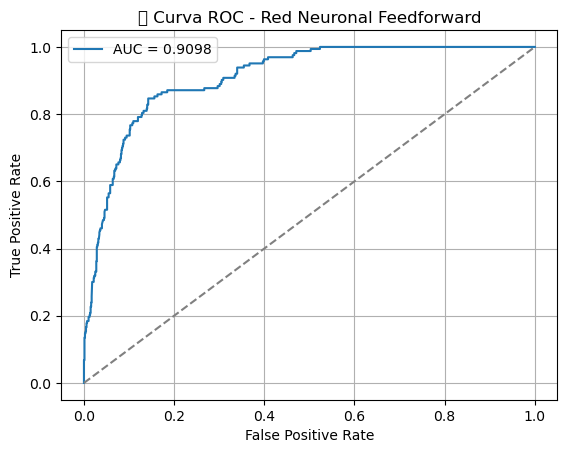

In [15]:
# 📌 Seleccionamos las 7 características más importantes
print("📊 Seleccionando las 7 características más relevantes para la red neuronal...")
top7_features = feat_imp_df['Feature'].head(7).tolist()
X_train_nn = X_train_res_scaled[top7_features]
X_test_nn = X_test_scaled[top7_features]

# 🧠 Función para capturar hiperparámetros con valores por defecto
def input_with_default(prompt, default, tipo=str):
    user_input = input(f"{prompt} (valor recomendado: {default}): ")
    if user_input.strip() == "":
        return tipo(default)
    try:
        return tipo(user_input)
    except ValueError:
        print(f"❗ Valor inválido, se usará el valor por defecto: {default}")
        return tipo(default)

# 🎛️ Ingreso de hiperparámetros
neurons = input_with_default("Número de neuronas en capa oculta", 40, int)
learning_rate = input_with_default("Learning rate para SGD", 0.005, float)
epochs = input_with_default("Cantidad máxima de épocas", 200, int)
batch_size = input_with_default("Batch size", 32, int)
patience = input_with_default("Paciencia para EarlyStopping", 30, int)

print(f"\n🧪 Configuración usada:\nNeurona(s): {neurons}\nLearning rate: {learning_rate}\nÉpocas: {epochs}\nBatch size: {batch_size}\nPaciencia EarlyStopping: {patience}\n")

# 🛠️ Construcción del modelo secuencial
model = Sequential([
    Input(shape=(7,)),
    Dense(neurons, activation='relu'),
    Dense(1, activation='sigmoid')
])  
optimizer = SGD(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])

# 🧱 EarlyStopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_AUC', patience=patience, mode='max', restore_best_weights=True)

# 🚀 Entrenamiento del modelo
history = model.fit(
    X_train_nn, y_train_res,
    validation_data=(X_test_nn, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

# 📈 Evaluación y curva ROC
print("\n🔍 Evaluando modelo en conjunto de prueba...")
y_pred_prob = model.predict(X_test_nn).ravel()
auc = roc_auc_score(y_test, y_pred_prob)
print(f"\n🧾 AUC en test: {auc:.4f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📊 Curva ROC - Red Neuronal Feedforward')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
# Imprime el análisis con el valor AUC obtenido
analysis_text = f"""
## 📈 Interpretación de la Curva ROC

La curva ROC muestra la relación entre la tasa de verdaderos positivos (True Positive Rate) y la tasa de falsos positivos (False Positive Rate) para diferentes umbrales de clasificación.

- El área bajo la curva (AUC) es **{auc:.4f}**, lo que indica un excelente desempeño del modelo.
- Un AUC cercano a 1 significa que el modelo tiene una alta capacidad para distinguir correctamente entre clientes que renuncian y los que no.
- La curva se aleja significativamente de la diagonal punteada (clasificador aleatorio), demostrando que la red neuronal tiene un buen poder predictivo.
- En resumen, la red neuronal feedforward es capaz de predecir con alta precisión la renuncia de clientes, validando su efectividad para este problema.

---

Este resultado confirma que la selección de variables y el diseño del modelo permitieron alcanzar un nivel de rendimiento sobresaliente en la predicción.
"""

print(analysis_text)



## 📈 Interpretación de la Curva ROC

La curva ROC muestra la relación entre la tasa de verdaderos positivos (True Positive Rate) y la tasa de falsos positivos (False Positive Rate) para diferentes umbrales de clasificación.

- El área bajo la curva (AUC) es **0.9098**, lo que indica un excelente desempeño del modelo.
- Un AUC cercano a 1 significa que el modelo tiene una alta capacidad para distinguir correctamente entre clientes que renuncian y los que no.
- La curva se aleja significativamente de la diagonal punteada (clasificador aleatorio), demostrando que la red neuronal tiene un buen poder predictivo.
- En resumen, la red neuronal feedforward es capaz de predecir con alta precisión la renuncia de clientes, validando su efectividad para este problema.

---

Este resultado confirma que la selección de variables y el diseño del modelo permitieron alcanzar un nivel de rendimiento sobresaliente en la predicción.



***EXTRA***

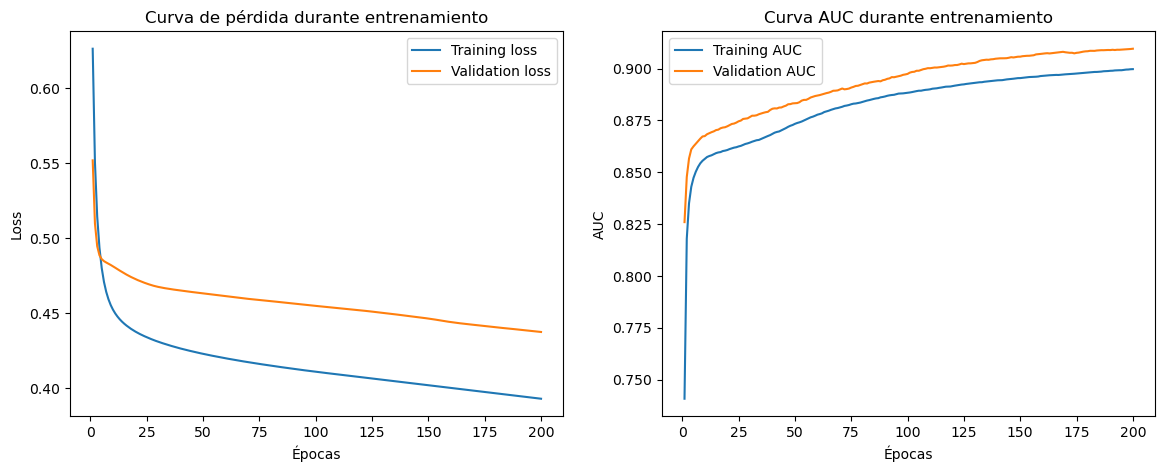

In [19]:
def plot_learning_curves(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Curva de pérdida (loss)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Curva de pérdida durante entrenamiento')
    plt.legend()

    # Curva de métrica AUC
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['AUC'], label='Training AUC')
    plt.plot(epochs, history.history['val_AUC'], label='Validation AUC')
    plt.xlabel('Épocas')
    plt.ylabel('AUC')
    plt.title('Curva AUC durante entrenamiento')
    plt.legend()

    plt.show()

plot_learning_curves(history)


## Interpretación de las Curvas de Aprendizaje durante el Entrenamiento

### Curva de pérdida (Loss)
- La curva de pérdida muestra cómo disminuye el error del modelo durante el entrenamiento y la validación.
- Se observa que tanto la pérdida en entrenamiento como en validación disminuyen de manera constante, lo que indica que el modelo está aprendiendo correctamente.
- La pérdida de validación se mantiene cercana a la pérdida de entrenamiento, lo que sugiere que no hay sobreajuste significativo.

### Curva AUC
- La curva AUC mide la capacidad del modelo para distinguir entre las clases (renuncia y no renuncia).
- Se aprecia que tanto el AUC de entrenamiento como el de validación aumentan progresivamente y se estabilizan en valores altos (>0.9).
- El AUC de validación es ligeramente superior al de entrenamiento, lo que indica un buen desempeño y generalización del modelo.

---

Estas curvas confirman que el modelo converge adecuadamente, aprende bien sin sobreajuste y tiene un excelente poder predictivo para clasificar la renuncia de clientes.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


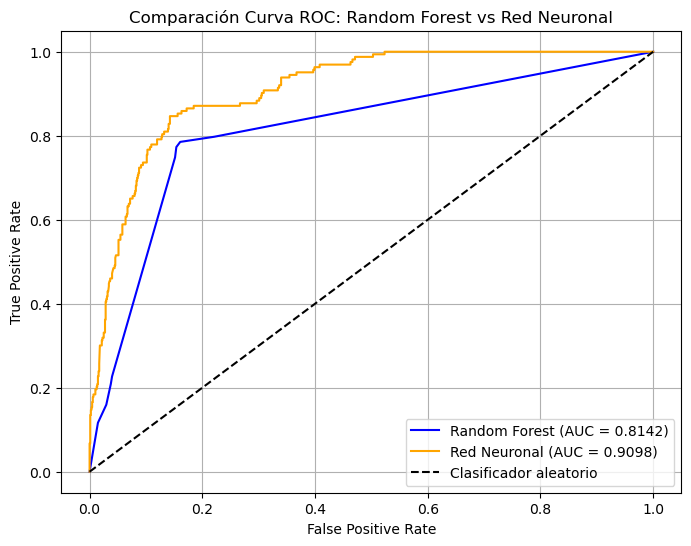

In [20]:
# Predecir probabilidades con Random Forest (probabilidad clase 1)
y_pred_rf_prob = rf.predict_proba(X_test)[:, 1]

# Predecir probabilidades con la red neuronal
y_pred_nn_prob = model.predict(X_test_nn).ravel()

# Calcular curvas ROC y AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
auc_rf = roc_auc_score(y_test, y_pred_rf_prob)

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_prob)
auc_nn = roc_auc_score(y_test, y_pred_nn_prob)

# Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', color='blue')
plt.plot(fpr_nn, tpr_nn, label=f'Red Neuronal (AUC = {auc_nn:.4f})', color='orange')
plt.plot([0,1], [0,1], 'k--', label='Clasificador aleatorio')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparación Curva ROC: Random Forest vs Red Neuronal')
plt.legend()
plt.grid(True)
plt.show()


## 📊 Comparación de Curvas ROC: Random Forest vs Red Neuronal

La gráfica muestra las curvas ROC de dos modelos para predecir la renuncia de clientes:

- **Random Forest** tiene un AUC de **0.8142**, mostrando un desempeño bueno pero con cierta limitación para discriminar correctamente entre las clases.
- **Red Neuronal Feedforward** obtiene un AUC superior, de **0.9098**, indicando un poder predictivo significativamente mejor.
- La curva de la red neuronal se aleja más de la línea diagonal (clasificador aleatorio), demostrando mayor capacidad para distinguir entre clientes que renuncian y los que no.
- La diferencia en AUC sugiere que la red neuronal capta patrones más complejos en los datos que el modelo Random Forest, mejorando la precisión de la predicción.

---

En resumen, la red neuronal supera en rendimiento al Random Forest en este problema, y es la opción recomendada para esta tarea de clasificación.


In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib


In [34]:
# Selección de variables más importantes
top7_features = ['Seconds of Use', 'Frequency of use', 'Customer Value',
                'Frequency of SMS', 'Distinct Called Numbers', 
                'Subscription  Length',
                'Status']

# Subconjuntos para entrenamiento y prueba
X_train_top7 = X_train_res[top7_features]
X_test_top7 = X_test[top7_features]


## 🧠 Selección de variables más importantes

Se identificaron las 7 características más relevantes según el modelo Random Forest:

- Seconds of Use  
- Frequency of use  
- Customer Value  
- Frequency of SMS  
- Distinct Called Numbers  
- Subscription  Length *(¡ojo! con doble espacio)*  
- Status  

A partir de estas, se construyen dos subconjuntos (`X_train_top7` y `X_test_top7`) que serán utilizados para entrenar y evaluar el modelo con un enfoque más simple y eficiente.


In [35]:
# Definimos el pipeline: escalado + modelo
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [36]:
# Entrenamos con los datos balanceados (SMOTE)
pipeline_rf.fit(X_train_top7, y_train_res)


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=42))])

## 🏁 Entrenamiento del pipeline completo

Se entrenó el pipeline `pipeline_rf`, que incluye dos pasos fundamentales:

1. `StandardScaler`: estandariza las variables para mejorar el aprendizaje.
2. `RandomForestClassifier`: modelo robusto para clasificación supervisada.

Este pipeline fue entrenado con:
- **X_train_top7** → Las 7 variables más importantes.
- **y_train_res** → Etiquetas balanceadas con SMOTE.

✅ El modelo ya está listo para:
- Validarse en test
- Ser guardado
- Realizar predicciones con nuevos datos reales o simulados


In [37]:
# Guardamos el pipeline completo en un archivo .pkl
joblib.dump(pipeline_rf, 'modelo_churn_rf.pkl')
print("✅ Modelo guardado como modelo_churn_rf.pkl")


✅ Modelo guardado como modelo_churn_rf.pkl


## 📄 Simulación de nuevos clientes para predicción

En este paso:

1. Se genera una cadena de texto con datos de nuevos clientes (simulados).
2. Se guarda en un archivo llamado `nuevos_clientes.csv`.
3. Se carga este archivo como un DataFrame (`nuevos`) para ser procesado por el modelo entrenado.

Estas observaciones contienen las 7 variables clave requeridas por el modelo de churn, y permiten simular la predicción en un entorno controlado.


In [38]:
# Creamos un archivo CSV con nuevos clientes directamente desde código
import pandas as pd

data_csv = """Seconds of Use,Frequency of use,Customer Value,Frequency of SMS,Distinct Called Numbers,Subscription  Length,Status
4000,70,450,60,30,24,1
1000,20,200,15,10,12,1
8000,150,700,90,50,48,2
"""

# Guardar el CSV
with open("nuevos_clientes.csv", "w") as f:
    f.write(data_csv)

# Leer el archivo
nuevos = pd.read_csv("nuevos_clientes.csv")
nuevos


,Seconds of Use,Frequency of use,Customer Value,Frequency of SMS,Distinct Called Numbers,Subscription Length,Status
0,4000,70,450,60,30,24,1
1,1000,20,200,15,10,12,1
2,8000,150,700,90,50,48,2


In [48]:
import joblib

# Cargamos el modelo
modelo = joblib.load("modelo_churn_rf.pkl")

# Cargamos el archivo o datos nuevos
nuevos = pd.read_csv("nuevos_clientes.csv")  # o crea el DataFrame manualmente

# Aseguramos que tenga SOLO las columnas que el modelo espera
columnas_modelo = ['Seconds of Use', 'Frequency of use', 'Customer Value',
                   'Frequency of SMS', 'Distinct Called Numbers',
                   'Subscription  Length', 'Status']  # ¡Ojo con el espacio doble!

nuevos = nuevos[columnas_modelo]  # Elimina cualquier otra columna

# Predecimos probabilidad de churn
nuevos["Prob_Churn"] = modelo.predict_proba(nuevos)[:, 1]

# Aplicamos regla de acción
nuevos["Requiere acción"] = nuevos["Prob_Churn"].apply(
    lambda x: "✅ Enviar promoción" if x > 0.7 else "❌ No urgente"
)

## 🔮 Predicción de churn en nuevos clientes + regla de acción

Este bloque permite predecir la probabilidad de cancelación (`Churn`) en nuevos clientes:

1. Se carga el modelo entrenado desde el archivo `.pkl`.
2. Se cargan los nuevos clientes desde el archivo `nuevos_clientes.csv`.
3. Se seleccionan exactamente las columnas esperadas por el modelo.
4. Se calcula la probabilidad de churn (`Prob_Churn`) para cada cliente.
5. Se aplica una regla de negocio:
   - Si `Prob_Churn > 0.7` → ✅ Enviar promoción
   - Si `Prob_Churn <= 0.7` → ❌ No urgente

El resultado es un DataFrame enriquecido con las decisiones de acción para cada cliente.


In [47]:
# Mostramos resultado final
nuevos

,Seconds of Use,Frequency of use,Customer Value,Frequency of SMS,Distinct Called Numbers,Subscription Length,Status,Prob_Churn,Requiere acción
0,4000,70,450,60,30,24,1,0.34,❌ No urgente
1,1000,20,200,15,10,12,1,0.25,❌ No urgente
2,8000,150,700,90,50,48,2,0.17,❌ No urgente


In [53]:
import pandas as pd
import numpy as np

# Semilla para reproducibilidad
np.random.seed(42)

# Generamos datos aleatorios para 100 clientes
nuevos = pd.DataFrame({
    'Seconds of Use': np.random.randint(500, 10000, size=100),
    'Frequency of use': np.random.randint(5, 200, size=100),
    'Customer Value': np.random.randint(100, 1000, size=100),
    'Frequency of SMS': np.random.randint(0, 150, size=100),
    'Distinct Called Numbers': np.random.randint(5, 100, size=100),
    'Subscription  Length': np.random.randint(1, 60, size=100),
    'Status': np.random.choice([1, 2, 3], size=100)  # Por ejemplo: 1 = activo, 2 = inactivo, 3 = suspendido
})

# Guardamos el archivo CSV
nuevos.to_csv("nuevos_clientes.csv", index=False)

print("✅ Archivo 'nuevos_clientes.csv' creado con éxito.")


✅ Archivo 'nuevos_clientes.csv' creado con éxito.


In [54]:
from IPython.display import FileLink

# Mostrar botón de descarga
FileLink("nuevos_clientes.csv")


C:\Users\Lenovo\nuevos_clientes.csv